In [2]:
#import necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [7]:
#import Data
PL19_20_fixtures = pd.read_csv('Data/2019-20/Fixtures/PL19_20_fixtures.csv')
PL20_21_fixtures = pd.read_csv('Data/2020-21/Fixtures/PL20_21_fixtures.csv')
PL21_22_fixtures = pd.read_csv('Data/2021-22/Fixtures/PL21_22_fixtures.csv')
#PL20_21_fixtures.replace(['Manchester Utd', 'Tottenham'], ['Manchester United','Tottenham Hotspur'], inplace=True)
PL19_20_fixtures['game_home_ID'] = PL19_20_fixtures['HomeTeam'] + PL19_20_fixtures['Date'].astype(str)
PL19_20_fixtures['game_away_ID'] = PL19_20_fixtures['AwayTeam'] + PL19_20_fixtures['Date'].astype(str)
PL20_21_fixtures['game_home_ID'] = PL20_21_fixtures['HomeTeam'] + PL20_21_fixtures['Date'].astype(str)
PL20_21_fixtures['game_away_ID'] = PL20_21_fixtures['AwayTeam'] + PL20_21_fixtures['Date'].astype(str)
PL21_22_fixtures['game_home_ID'] = PL21_22_fixtures['HomeTeam'] + PL21_22_fixtures['Date'].astype(str)
PL21_22_fixtures['game_away_ID'] = PL21_22_fixtures['AwayTeam'] + PL21_22_fixtures['Date'].astype(str)
PL21_22_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Rating_Home,Rating_Away,Rating difference,game_home_ID,game_away_ID
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,2.13,2.05,2.17,1.80,2.09,73,79,-6,Brentford2021-08-13,Arsenal2021-08-13
1,E0,2021-08-14,12:30,Manchester Utd,Leeds United,5,1,H,1,0,...,1.77,2.19,1.93,2.10,1.79,83,76,7,Manchester Utd2021-08-14,Leeds United2021-08-14
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,2.14,1.82,2.19,1.79,2.12,76,75,1,Burnley2021-08-14,Brighton2021-08-14
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.81,2.16,1.93,2.06,1.82,83,76,7,Chelsea2021-08-14,Crystal Palace2021-08-14
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,1.88,2.08,1.90,2.03,1.86,79,76,3,Everton2021-08-14,Southampton2021-08-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,0,...,2.23,1.88,2.25,1.74,2.16,76,83,-7,Crystal Palace2022-05-22,Manchester Utd2022-05-22
376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,0,...,2.03,1.94,2.26,1.87,2.01,80,76,4,Leicester City2022-05-22,Southampton2022-05-22
377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,1,...,1.83,2.19,1.99,2.07,1.80,84,78,6,Liverpool2022-05-22,Wolves2022-05-22
378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,1,...,1.86,2.09,2.03,2.01,1.87,85,78,7,Manchester City2022-05-22,Aston Villa2022-05-22


In [8]:
#generate gameweeks dependening on the order of the games
def generate_gameweeks(df):
    teams = df.HomeTeam.unique().tolist()
    df['Wk_h'] = 0
    df['Wk_a'] = 0
    for team in teams:
        count = 1
        for index, row in df.iterrows():
            if row['HomeTeam'] == team:
                df.at[index, 'Wk_h'] = count
                count = count + 1
            elif row['AwayTeam'] == team:
                df.at[index, 'Wk_a'] = count
                count = count + 1
    return df

PL19_20_fixtures = generate_gameweeks(PL19_20_fixtures)
PL20_21_fixtures = generate_gameweeks(PL20_21_fixtures)
PL21_22_fixtures = generate_gameweeks(PL21_22_fixtures)

PL21_22_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHA,AvgCAHH,AvgCAHA,Rating_Home,Rating_Away,Rating difference,game_home_ID,game_away_ID,Wk_h,Wk_a
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,2.17,1.80,2.09,73,79,-6,Brentford2021-08-13,Arsenal2021-08-13,1,1
1,E0,2021-08-14,12:30,Manchester Utd,Leeds United,5,1,H,1,0,...,1.93,2.10,1.79,83,76,7,Manchester Utd2021-08-14,Leeds United2021-08-14,1,1
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,2.19,1.79,2.12,76,75,1,Burnley2021-08-14,Brighton2021-08-14,1,1
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.93,2.06,1.82,83,76,7,Chelsea2021-08-14,Crystal Palace2021-08-14,1,1
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,1.90,2.03,1.86,79,76,3,Everton2021-08-14,Southampton2021-08-14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,0,...,2.25,1.74,2.16,76,83,-7,Crystal Palace2022-05-22,Manchester Utd2022-05-22,38,38
376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,0,...,2.26,1.87,2.01,80,76,4,Leicester City2022-05-22,Southampton2022-05-22,38,38
377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,1,...,1.99,2.07,1.80,84,78,6,Liverpool2022-05-22,Wolves2022-05-22,38,38
378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,1,...,2.03,2.01,1.87,85,78,7,Manchester City2022-05-22,Aston Villa2022-05-22,38,38


In [628]:
#functions for feature Engineering
def get_points(team, wk):
    for index, row in PL20_21_fixtures.iterrows():
        #print(row[['HomeTeam','Wk']])
        if row['Wk_h'] == wk and row['HomeTeam'] == team:
            if row['FTR'] == 'H':
                return 3
            if row['FTR'] == 'D':
                return 1
            else:
                return 0
        if row['Wk_a'] == wk and row['AwayTeam'] == team:
            if row['FTR'] == 'A':
                return 3
            if row['FTR'] == 'D':
                return 1
            else:
                return 0


def get_stats(team, wk, stat):
    for index, row in PL20_21_fixtures.iterrows():
        #print(row[['HomeTeam','Wk']])
        if row['Wk_h'] == wk and row['HomeTeam'] == team:
            if stat == 'goals':
                return row['FTHG']
            elif stat == 'shots':
                return row['HST']
            elif stat == 'corners':
                return row['HC']
        elif row['Wk_a'] == wk and row['AwayTeam'] == team:
            if stat == 'goals':
                return row['FTAG']
            elif stat == 'shots':
                return row['AST']
            elif stat == 'corners':
                return row['AC']
            return row[stat]


def get_points_season(team, fr, to):
    test = []
    out = 0
    df2 = 0
    if fr == to: return 0
    for i in range(fr, to):
        out = out + get_points(team, i)
        test.append(out)
        df = pd.Series(test)
        df2 = df.rolling(len(df)).mean()
        df2 = df2[len(df) - 1]
        #print(df2[len(df)-1])
        #print(df2)
    return df2


def get_stats_season(team, fr, to, category):
    test = []
    out = 0
    df2 = 0
    if fr == to: return 0
    for i in range(fr, to):
        out = out + get_stats(team, i, category)
        test.append(out)
        df = pd.Series(test)
        df2 = df.rolling(len(df)).mean()
        df2 = df2[len(df) - 1]
        #df2 = df.ewm(alpha=0.4).mean()[len(df) - 1]
    return df2


def get_ewm_season(team, fr, to):
    test = []
    out = 0
    if fr == to: return 0
    for i in range(fr, to):
        out = out + get_points(team, i)
        test.append(out)
        df = pd.Series(test)
        df2 = df.ewm(alpha=0.4).mean()[len(df) - 1]
    return df2


def append_form(timespan):
    formH = []
    formA = []
    for index, row in PL20_21_fixtures.iterrows():
        wk_h = row['Wk_h']
        wk_a = row['Wk_a']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk_h) - timespan < 1:
            pointsH = get_points_season(teamH, 1, int(wk_h) - 1)
        else:
            pointsH = get_points_season(teamH, int(wk_h) - timespan, int(wk_h) - 1)
        if int(wk_a) - timespan < 1:
            pointsA = get_points_season(teamA, 1, int(wk_a) - 1)
        else:
            pointsA = get_points_season(teamA, int(wk_a) - timespan, int(wk_a) - 1)
        formH.append(pointsH)
        formA.append(pointsA)
    PL20_21_fixtures['formH'] = formH
    PL20_21_fixtures['formA'] = formA


def append_ewm(timespan):
    formH = []
    formA = []
    for index, row in PL20_21_fixtures.iterrows():
        wk_h = row['Wk_h']
        wk_a = row['Wk_a']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk_h) - timespan < 1:
            pointsH = get_ewm_season(teamH, 1, int(wk_h))
        else:
            pointsH = get_ewm_season(teamH, int(wk_h) - timespan, int(wk_h) - 1)
        if int(wk_a) - timespan < 1:
            pointsA = get_ewm_season(teamA, 1, int(wk_a))
        else:
            pointsA = get_ewm_season(teamA, int(wk_a) - timespan, int(wk_a) - 1)
        formH.append(pointsH)
        formA.append(pointsA)
    PL20_21_fixtures['ewmH'] = formH
    PL20_21_fixtures['ewmA'] = formA


def append_stats(timespan):
    goals_h = []
    goals_A = []
    shots_H = []
    shots_A = []
    corners_H = []
    corners_A = []

    for index, row in PL20_21_fixtures.iterrows():
        wk_h = row['Wk_h']
        wk_a = row['Wk_a']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk_h) - timespan < 1:
            goalsH = get_stats_season(teamH, 1, int(wk_h) - 1, 'goals')
            shotsH = get_stats_season(teamH, 1, int(wk_h) - 1, 'shots')
            cornersH = get_stats_season(teamH, 1, int(wk_h) - 1, 'corners')
        else:
            goalsH = get_stats_season(teamH, int(wk_h) - timespan, int(wk_h) - 1, 'goals')
            shotsH = get_stats_season(teamH, int(wk_h) - timespan, int(wk_h) - 1, 'shots')
            cornersH = get_stats_season(teamH, int(wk_h) - timespan, int(wk_h) - 1, 'corners')

        if int(wk_a) - timespan < 1:
            goalsA = get_stats_season(teamA, 1, int(wk_a) - 1, 'goals')
            shotsA = get_stats_season(teamA, 1, int(wk_a) - 1, 'shots')
            cornersA = get_stats_season(teamA, 1, int(wk_a) - 1, 'corners')
        else:
            goalsA = get_stats_season(teamA, int(wk_a) - timespan, int(wk_a) - 1, 'goals')
            shotsA = get_stats_season(teamA, int(wk_a) - timespan, int(wk_a) - 1, 'shots')
            cornersA = get_stats_season(teamA, int(wk_a) - timespan, int(wk_a) - 1, 'corners')

        goals_h.append(goalsH)
        goals_A.append(goalsA)
        shots_H.append(shotsH)
        shots_A.append(shotsA)
        corners_H.append(cornersH)
        corners_A.append(cornersA)
    PL20_21_fixtures['goalsH'] = goals_h
    PL20_21_fixtures['goalsA'] = goals_A
    PL20_21_fixtures['shotsH'] = shots_H
    PL20_21_fixtures['shotsA'] = shots_A
    PL20_21_fixtures['cornersH'] = corners_H
    PL20_21_fixtures['cornersA'] = corners_A


#Elo Rating
def expected_result(loc, aw):
    dr = loc - aw
    we = (1 / (10 ** (-dr / 400) + 1))
    return [np.round(we, 3), 1 - np.round(we, 3)]


def actual_result(loc, aw):
    if loc < aw:
        wa = 1
        wl = 0
    elif loc > aw:
        wa = 0
        wl = 1
    elif loc == aw:
        wa = 0.5
        wl = 0.5
    return [wl, wa]


def calculate_elo(elo_l, elo_v, local_goals, away_goals, k_value):
    k = k_value
    wl, wv = actual_result(local_goals, away_goals)
    wel, wev = expected_result(elo_l, elo_v)

    elo_ln = elo_l + k * (wl - wel)
    elo_vn = elo_v + k * (wv - wev)

    return elo_ln, elo_vn

In [629]:
def get_points_side(team, wk, home):
    for index, row in PL20_21_fixtures.iterrows():
        if row['Wk_h'] == wk and row['HomeTeam'] == team and home == True:
            if row['FTR'] == 'H':
                return 3
            if row['FTR'] == 'D':
                return 1
            else:
                return 0
        if row['Wk_a'] == wk and row['AwayTeam'] == team and home == False:
            if row['FTR'] == 'A':
                return 3
            if row['FTR'] == 'D':
                return 1
            else:
                return 0
    if wk > 2:
        return get_points_side(team, wk - 1, home)
    else:
        return 0


def get_points_season_side(team, fr, to, home):
    out = 0
    for i in range(fr, to):
        out = out + get_points_side(team, i, home)
    return out


def append_form_side(timespan):
    formH = []
    formA = []
    for index, row in PL20_21_fixtures.iterrows():
        wk_h = row['Wk_h']
        wk_a = row['Wk_a']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk_h) - timespan < 1:
            pointsH = get_points_season_side(teamH, 1, int(wk_h) - 1, True)
        else:
            pointsH = get_points_season_side(teamH, int(wk_h) - timespan, int(wk_h) - 1, True)
        if int(wk_a) - timespan < 1:
            pointsA = get_points_season_side(teamA, 1, int(wk_a) - 1, False)
        else:
            pointsA = get_points_season_side(teamA, int(wk_a) - timespan, int(wk_a) - 1, False)
        formH.append(pointsH)
        formA.append(pointsA)
    PL20_21_fixtures['formH_side'] = formH
    PL20_21_fixtures['formA_side'] = formA


In [630]:
#add features to table
append_stats(7)
append_ewm(40)
append_form(7)

#append_form_side(7)
#print(get_points_side( 'Arsenal', 1, True))

In [631]:
PL20_21_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,goalsH,goalsA,shotsH,shotsA,cornersH,cornersA,ewmH,ewmA,formH,formA
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,E0,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,E0,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,6.166667,3.666667,28.500000,12.000000,25.166667,12.333333,61.786751,42.472970,7.500000,2.000000
376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,0,...,6.166667,4.000000,15.666667,14.000000,21.666667,15.666667,81.106115,56.386935,7.000000,5.333333
377,E0,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,1,0,...,0.833333,5.666667,6.666667,15.000000,11.166667,23.666667,18.674571,38.074699,2.500000,3.000000
378,E0,2021-05-23,16:00,West Ham United,Southampton,3,0,H,2,0,...,5.833333,3.000000,12.833333,16.333333,14.500000,21.166667,59.287588,41.132084,4.666667,2.166667


In [632]:
#calculate Elo scores
current_elo = {}
for idx, row in PL20_21_fixtures.iterrows():

    local = row['HomeTeam']
    away = row['AwayTeam']
    local_goals = row['FTHG']
    away_goals = row['FTAG']
    #tournament = row['tournament']

    if local not in current_elo.keys():
        current_elo[local] = 1500

    if away not in current_elo.keys():
        current_elo[away] = 1500

    elo_l = current_elo[local]
    elo_v = current_elo[away]
    elo_ln, elo_vn = calculate_elo(elo_l, elo_v, local_goals, away_goals, 30)

    current_elo[local] = elo_ln
    current_elo[away] = elo_vn

    PL20_21_fixtures.loc[idx, 'Elo_h_after'] = elo_ln
    PL20_21_fixtures.loc[idx, 'Elo_a_after'] = elo_vn
    PL20_21_fixtures.loc[idx, 'Elo_h_before'] = elo_l
    PL20_21_fixtures.loc[idx, 'Elo_a_before'] = elo_v

In [634]:
#calculate Differences
PL20_21_fixtures['goalsDifference'] = PL20_21_fixtures['goalsH'] - PL20_21_fixtures['goalsA']
PL20_21_fixtures

PL20_21_fixtures['shotsDifference'] = PL20_21_fixtures['shotsH'] - PL20_21_fixtures['shotsA']
PL20_21_fixtures

PL20_21_fixtures['cornersDifference'] = PL20_21_fixtures['cornersH'] - PL20_21_fixtures['cornersA']
PL20_21_fixtures

PL20_21_fixtures['ewmDifference'] = PL20_21_fixtures['ewmH'] - PL20_21_fixtures['ewmA']
PL20_21_fixtures

PL20_21_fixtures['elo_difference'] = PL20_21_fixtures['Elo_h_before'] - PL20_21_fixtures['Elo_a_before']
PL20_21_fixtures

PL20_21_fixtures['form_difference'] = PL20_21_fixtures['formH'] - PL20_21_fixtures['formA']
PL20_21_fixtures

#PL20_21_fixtures['form_difference_side'] = PL20_21_fixtures['formH_side'] - PL20_21_fixtures['formA_side']
PL20_21_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,E0,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,0,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,E0,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,0,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,1591.89,1439.73,1582.38,1449.24,2.500000,16.500000,12.833333,19.313782,133.14,5.500000
376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,0,...,1659.36,1508.70,1649.79,1518.27,2.166667,1.666667,6.000000,24.719180,131.52,1.666667
377,E0,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,1,0,...,1358.16,1420.86,1338.90,1440.12,-4.833333,-8.333333,-12.500000,-19.400129,-101.22,-0.500000
378,E0,2021-05-23,16:00,West Ham United,Southampton,3,0,H,2,0,...,1560.00,1420.08,1549.98,1430.10,2.833333,-3.500000,-6.666667,18.155503,119.88,2.500000


In [635]:
rslt_df = PL20_21_fixtures[PL20_21_fixtures['HomeTeam'] == 'Liverpool']
#rslt_df2 = PL20_21_fixtures[PL20_21_fixtures['AwayTeam'] == 'Liverpool' ]
rslt_df
#rslt_df.append(rslt_df2).sort_index()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
27,E0,2020-09-28,20:00,Liverpool,Arsenal,3,1,H,2,1,...,1544.94,1513.77,1530.00,1528.71,1.000000,0.000000,6.000000,0.000000,1.29,0.000000
52,E0,2020-10-24,20:00,Liverpool,Sheffield United,2,1,H,1,1,...,1541.73,1432.92,1530.36,1444.29,7.250000,11.250000,4.000000,8.381679,86.07,6.750000
61,E0,2020-10-31,17:30,Liverpool,West Ham United,2,1,H,1,1,...,1555.20,1492.41,1541.73,1505.88,3.600000,7.600000,10.200000,4.274168,35.85,4.200000
85,E0,2020-11-22,19:15,Liverpool,Leicester City,3,0,H,2,0,...,1569.15,1540.74,1554.06,1555.83,-1.333333,8.166667,1.666667,0.071603,-1.77,0.500000
105,E0,2020-12-06,19:15,Liverpool,Wolverhampton Wanderers,4,0,H,1,0,...,1578.72,1514.88,1565.31,1528.29,3.166667,9.500000,3.166667,4.230733,37.02,-2.666667
123,E0,2020-12-16,20:00,Liverpool,Tottenham Hotspur,2,1,H,1,1,...,1587.63,1557.00,1572.66,1571.97,2.166667,8.666667,2.000000,0.167494,0.69,-1.333333
145,E0,2020-12-27,16:30,Liverpool,West Bromwich Albion,1,1,D,1,0,...,1591.11,1411.41,1598.73,1403.79,5.166667,11.166667,-5.166667,20.797890,194.94,4.333333
176,E0,2021-01-17,16:30,Liverpool,Manchester United,0,0,D,0,0,...,1570.41,1600.29,1569.00,1601.70,1.833333,1.166667,6.666667,-0.230326,-32.70,0.333333
183,E0,2021-01-21,20:00,Liverpool,Burnley,0,1,A,0,0,...,1550.46,1471.23,1570.41,1451.28,5.166667,11.000000,13.166667,17.610074,119.13,-0.500000


In [636]:
test = PL20_21_fixtures['FTR']
test.value_counts()

A    153
H    144
D     83
Name: FTR, dtype: int64

In [637]:
#elos=PL20_21_fixtures[['Date_x','HomeTeam','Elo_h_after']].rename(columns={'home_team':'Team','Elo_h_after':'Elo'}).append(PL20_21_fixtures[['Date_x','AwayTeam','Elo_a_after']].rename(columns={'away_team':'Team','Elo_a_after':'Elo'}))
#elos

In [638]:
PL20_21_fixtures.to_csv('Data/2020-21/Fixtures/PL20_21_features.csv')

In [639]:
PL20_21_features = pd.read_csv('Data/2020-21/Fixtures/PL20_21_features.csv')
PL20_21_features

,Unnamed: 0,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
0,0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,3,E0,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,4,E0,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,...,1591.89,1439.73,1582.38,1449.24,2.500000,16.500000,12.833333,19.313782,133.14,5.500000
376,376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,...,1659.36,1508.70,1649.79,1518.27,2.166667,1.666667,6.000000,24.719180,131.52,1.666667
377,377,E0,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,1,...,1358.16,1420.86,1338.90,1440.12,-4.833333,-8.333333,-12.500000,-19.400129,-101.22,-0.500000
378,378,E0,2021-05-23,16:00,West Ham United,Southampton,3,0,H,2,...,1560.00,1420.08,1549.98,1430.10,2.833333,-3.500000,-6.666667,18.155503,119.88,2.500000


In [640]:
#prepare Data for ML Algos
#add column for H A X
conditions = [
    (PL20_21_features['FTR'] == 'H'),
    (PL20_21_features['FTR'] == 'A'),
    (PL20_21_features['FTR'] == 'D')]
choices = [0, 1, 2]
PL20_21_features['identifier'] = np.select(conditions, choices)
#PL20_21_features.drop(PL20_21_features[ PL20_21_features.Wk < 6].index, inplace=True)
y = PL20_21_features['identifier'].to_numpy()
feature_names = ['Rating difference', 'Rating_Home', 'Rating_Away', 'ewmH', 'ewmA', 'ewmDifference', 'Elo_h_before',
                 'Elo_a_before', 'elo_difference', 'goalsH', 'goalsA', 'goalsDifference', 'shotsH', 'shotsA',
                 'shotsDifference', 'cornersH', 'cornersA', 'cornersDifference', 'formH', 'formA', 'form_difference']
#feature_names = ['Rating difference', 'elo_difference', 'ewmDifference', 'goalsDifference', 'shotsDifference', 'cornersDifference', 'form_difference']
X = PL20_21_features[feature_names].to_numpy()
#X = PL20_21_features[['Rating difference', 'eloA', 'eloDifference' ]].to_numpy()


In [641]:
#split Data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [642]:
#create manual test and training sets, without gw 1-3
X_train21 = np.split(X, [40, 340, 380], axis=0)
X_train2 = X_train21[1]
X_test2 = X_train21[2]
y_train21 = np.split(y, [40, 340, 380], axis=0)
y_train2 = y_train21[1]
y_test2 = y_train21[2]

In [643]:
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')
print(f'X_train2 : {X_train2.shape}')
print(f'y_train2 : {y_train2.shape}')
print(f'X_test2 : {X_test2.shape}')
print(f'y_test2 : {y_test2.shape}')

X_train : (304, 21)
y_train : (304,)
X_test : (76, 21)
y_test : (76,)
X_train2 : (300, 21)
y_train2 : (300,)
X_test2 : (40, 21)
y_test2 : (40,)


In [644]:
#set up classifiers
rf_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier(seed=82)
rf_model2 = RandomForestClassifier()
xgb_model2 = xgb.XGBClassifier(seed=82)

In [645]:
rf_model2.fit(X_train2, y_train2)
xgb_model2.fit(X_train2, y_train2)
rf_model2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [646]:
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [647]:
rf_model.score(X_test, y_test)

0.4868421052631579

In [648]:
rf_model2.score(X_test2, y_test2)

0.6

In [649]:
xgb_model.score(X_test, y_test)

0.47368421052631576

In [650]:
xgb_model2.score(X_test2, y_test2)

0.525

In [651]:
rf1 = []
rf2 = []
xg1 = []
xg2 = []
x = 0
for i in range(100):
    #split Data in training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #create manual test and training sets, without gw 1-3
    X_train21 = np.split(X, [40, 340, 380], axis=0)
    X_train2 = X_train21[1]
    X_test2 = X_train21[2]
    y_train21 = np.split(y, [40, 340, 380], axis=0)
    y_train2 = y_train21[1]
    y_test2 = y_train21[2]
    #set up classifiers
    rf_model = RandomForestClassifier()
    xgb_model = xgb.XGBClassifier(seed=82)
    rf_model2 = RandomForestClassifier()
    xgb_model2 = xgb.XGBClassifier(seed=82)
    rf_model2.fit(X_train2, y_train2)
    xgb_model2.fit(X_train2, y_train2)
    rf_model2.get_params()
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    rf_model.get_params()
    rf1.append(rf_model.score(X_test, y_test))
    rf2.append(rf_model2.score(X_test2, y_test2))
    xg1.append(xgb_model.score(X_test, y_test))
    xg2.append(xgb_model2.score(X_test2, y_test2))


In [652]:
def Average(lst):
    return sum(lst) / len(lst)


print('RF1', Average(rf1))
print('RF2', Average(rf2))
print('XGB1', Average(xg1))
print('XGB2', Average(xg2))

RF1 0.5210526315789478
RF2 0.5122500000000002
XGB1 0.4736842105263152
XGB2 0.524999999999999


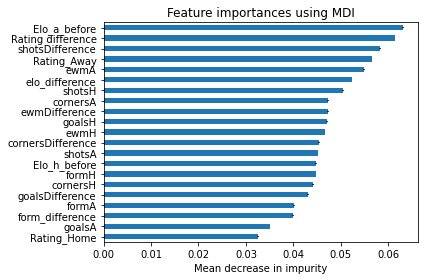

In [653]:
    #start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
#elapsed_time = time.time() - start_time


#feature_names = [f"feature {i}" for i in range(X.shape[1])]


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()

forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

In [654]:
#for measuring training time
from time import time
# F1 score (also F-score or F-measure) is a measure of a test's accuracy.
#It considers both the precision p and the recall r of the test to compute
#the score: p is the number of correct positive results divided by the number of
#all positive results, and r is the number of correct positive results divided by
#the number of positive results that should have been returned. The F1 score can be
#interpreted as a weighted average of the precision and recall, where an F1 score
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score


def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''

    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()

    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))


def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''

    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)

    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))

    return f1_score(target, y_pred, average='weighted'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''

    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))

    # Train the classifier
    train_classifier(clf, X_train, y_train)

    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1, acc))

    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1, acc))

In [655]:
train_predict(xgb_model, X_train, y_train, X_test, y_test)
print('')
train_predict(rf_model, X_train, y_train, X_test, y_test)

Training a XGBClassifier using a training set size of 304. . .
Trained model in 0.2005 seconds
Made predictions in 0.0040 seconds.
1.0 1.0
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0030 seconds.
F1 score and accuracy score for test set: 0.4328 , 0.4737.

Training a RandomForestClassifier using a training set size of 304. . .
Trained model in 0.1470 seconds
Made predictions in 0.0120 seconds.
1.0 1.0
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0080 seconds.
F1 score and accuracy score for test set: 0.5036 , 0.5658.
